## Perform Hierarchical Clustering on 3D coordinates
Here we perform hierarchial clustering on XYZ coordinates and plot branches by average transcriptional signature

In [1]:
from scipy.cluster.hierarchy import dendrogram, linkage  
from scipy.cluster.hierarchy import fcluster
from scipy.cluster.hierarchy import cophenet
from scipy.spatial.distance import pdist

import numpy as np
import py3Dmol
from ipywidgets import interact, IntSlider
import pandas as pd
pd.set_option('display.expand_frame_repr', False)
pd.set_option('display.max_columns', 500)
import matplotlib.pyplot as plt
from matplotlib import interactive
interactive(True)
import seaborn as sns
sns.set(style="whitegrid")

import ast
import math

from IPython.display import display, HTML

display(HTML(data="""
<style>
    div#notebook-container    { width: 95%; }
    div#menubar-container     { width: 65%; }
    div#maintoolbar-container { width: 99%; }
</style>
"""))

#### Input parameters

In [2]:
pathway = 'NRF2'

In [29]:
input_file_name = '../analysis/NRF2_pathway/dataframes/step2/mutations_NRF2v2_step2C.csv' # mutations with XYZ coordinates
output_file_name = '../analysis/NRF2_pathway/dataframes/step3/mutations_NRF2v2_step3.csv' # clusters of mutations

path = '../analysis/NRF2_pathway/dataframes/step3/'
path_test_train = '/home/ebc/variome/GIT/omphalos/analysis/NRF2_pathway/dataframes/step3/test_train_sets'

In [4]:

df_detailed = pd.read_csv(input_file_name,index_col=0)

columns_to_drop = [i for i in df_detailed.columns if 'PTM' in i ] + [i for i in df_detailed.columns if 'Ligand' in i ] +[i for i in df_detailed.columns if 'Drug' in i ]
df = df_detailed.drop(columns_to_drop,1)

### Merge RNA signature with DataFrame

In [5]:
RNA_signature_file = '../data/GSEA/CCLE_expression_full.reformatted.NRF2_signature.gct'

rna = pd.read_table(RNA_signature_file, header=0, sep='\t', skiprows=2)
rna.rename(columns={0:'Tumor_Sample_Barcode',1:'RNA_signature'},inplace=True)
target = rna.iloc[0,2:]
target = (target - target.mean())/(target.std())
target.to_csv(path+'/CCLE_{}_target.gct'.format(pathway), sep='\t')


# reformat RNA signature for DF
struct = []
for i in target.index:
    struct.append({'Tumor_Sample_Barcode':i,'RNA_signature':target[i]})        

df = df.merge(pd.DataFrame(struct), on='Tumor_Sample_Barcode', how = 'outer')

## Perform hierarchial clustering across PDB chains


    X samples (n x m array), aka data points or "singleton clusters"
    n number of samples
    m number of features
    Z cluster linkage array (contains the hierarchical clustering information)
    k number of clusters


In [6]:
def fancy_dendrogram(*args, **kwargs):
    max_d = kwargs.pop('max_d', None)
    if max_d and 'color_threshold' not in kwargs:
        kwargs['color_threshold'] = max_d
    annotate_above = kwargs.pop('annotate_above', 0)

    ddata = dendrogram(*args, **kwargs)

    if not kwargs.get('no_plot', False):
        plt.title('Hierarchical Clustering Dendrogram (truncated)')
        plt.xlabel('sample index or (cluster size)')
        plt.ylabel('distance')
        
        for i, d, c in zip(ddata['icoord'], ddata['dcoord'], ddata['color_list']):
            x = 0.5 * sum(i[1:3])
            y = d[1]
            
            
            if y > annotate_above:
                #print("%.3g" % y)
                
                plt.plot(x, y, 'o', c=c)
                plt.annotate("%.3g" % y, (x, y), xytext=(0, -5),
                             textcoords='offset points',
                             va='top', ha='center')
        if max_d:
            plt.axhline(y=max_d, c='k')
    return ddata

In [7]:
import copy

def get_member_info_and_computes_R_stats(i,j,m,DFZ):
    ''' takes in i of original df index of dataframe and j member'''

    tmp = copy.deepcopy(DFZ.iloc[i])

    # tt =  slice of df ~ selected by Hugo_Symbol and structureChainId
    rna = tt[tt.index==j]['RNA_signature'].values
    if len(rna) > 0:
        rna = rna[0]
    else:
        rna = -1000
        

    tmp['member_idx'] = j
    tmp['group_member_idx'] = m
    tmp['pdbResNum'] = tt[tt.index==j]['targetGroupNumber'].values[0] 
    tmp['R'] = rna
    tmp['Tumor_Sample_Barcode'] = tt[tt.index==j]['Tumor_Sample_Barcode'].values[0]
    tmp['Protein_Change'] = tt[tt.index==j]['Protein_Change'].values[0]
    tmp['uniprotId'] = tt[tt.index==j]['uniprotId'].values[0]
    tmp['var_x'] = tt[tt.index==j]['cluster_x'].values[0]
    tmp['var_y'] = tt[tt.index==j]['cluster_y'].values[0]
    tmp['var_z'] = tt[tt.index==j]['cluster_z'].values[0]
    

    #for cluster stats
    R = [o for o in tt[tt.index.isin(m)]['RNA_signature'].values.tolist() if ~np.isnan(o)]
    tmp['num_with_R'] = len(R)

    # compute averages of R across members
    if len([o for o in R if o>0])>0:
        tmp['avg_R_+'] = np.mean([o for o in R if o>0])
        tmp['std_R_+'] = np.std([o for o in R if o>0])
        tmp['num_with_R+'] = len([o for o in R if o>0])
    else:
        tmp['avg_R_+'] = None
        tmp['std_R_+'] = None
        tmp['num_with_R+'] = 0 

    if len([o for o in R if o<0]) > 0:
        tmp['avg_R_-'] = np.mean([o for o in R if o<0])
        tmp['std_R_-'] = np.std([o for o in R if o<0])
        tmp['num_with_R-'] = len([o for o in R if o<0])

    else:
        tmp['avg_R_-'] = None
        tmp['std_R_-'] = None
        tmp['num_with_R-'] = 0 

    if len(R)>0:
        tmp['avg_abs_R'] = np.mean(np.abs(R))
        tmp['std_abs_R'] = np.std(np.abs(R))
    else:
        tmp['avg_abs_R'] = None
        tmp['std_abs_R'] = None
        
    return(tmp)
          
                
def retrieve_R_across_branches(tt,Z):
    ''' Transforms clustering matrix into dataframe, Depends on get_member_info_and_computes_R_stats'''

    # used for distinguishing cluster groups
    string_abc = ['a','b','c','d','e','f','g','h','i','j','k','l','m','n','o','p','q','r','s','t','u','v','w','x','y','z','aa','bb','cc','dd','ee','ff','gg','hh','ii','jj','kk','ll','mm','nn','oo','pp','qq','rr','ss','tt','uu','vv','ww','xx','yy','zz','aaa','bbb','ccc','ddd','eee','fff','ggg','hhh','iii','jjj','kkk','lll','mmm','nnn','ooo','ppp','qqq','rrr','sss','ttt','uuu','vvv','www','xxx','yyy','zzz','0','1','2','3','4','5','6','7','8','9']
    
    # make cluster matrix into dataframe
    DFZ = pd.DataFrame(Z)
    DFZ.columns = ['idx1','idx2','dist','num_members']
    DFZ['index_of_members'] = [[] for i in DFZ.index]
    DFZ['resnum_of_members'] = [[] for i in DFZ.index]
    
    DFZ1 = pd.DataFrame()
    
    # initiate count for cluster groups
    c = -1
    
    # loop over clustering matrix
    for i in DFZ.index:
        
        c += 1

        i1 = int(DFZ.loc[i]['idx1'])
        i2 = int(DFZ.loc[i]['idx2'])
        
        # here i1 and i2 = index of the member up until len(X)
        if i1 < len(X) and i2 < len(X):
            
            # find membership in branch
            m = [i1,i2]
            DFZ.at[i,'index_of_members'] = m
            
            res_list = []
            
            for j in m:
                                
                tmp = get_member_info_and_computes_R_stats(i,j,m,DFZ)
                #tmp['cluster_grp'] = '_'+string_abc[c]+'_'            
          
                # concat to final DF                    
                DFZ1 = pd.concat([DFZ1,pd.DataFrame(tmp).T])
                
                # get resnums for members (used to determine cluster if resnum is the same)
                res_list.append(tmp.pdbResNum)
                
            DFZ.at[i,'resnum_of_members'] = res_list
            
                                
        # here only i1 = index of member, i2 = previous cluster index
        if i1 <len(X) and i2>=len(X):

            # find membership in branch
            m = [i1] + DFZ.iloc[i2 - len(X)]['index_of_members']
            DFZ.at[i,'index_of_members'] = m
            
            res_list = []
            
            for j in m:
                
                # call routine to get info on members
                tmp = get_member_info_and_computes_R_stats(i,j,m,DFZ)
          
                # concat to final DF                    
                DFZ1 = pd.concat([DFZ1,pd.DataFrame(tmp).T])      
                
                # get resnums for members (used to determine cluster if resnum is the same)
                res_list.append(tmp.pdbResNum)
                
            DFZ.at[i,'resnum_of_members'] = res_list
            
            
        if i1 >=len(X) and i2>=len(X):
            # find membership in branch
            m = DFZ.loc[i1 - len(X)]['index_of_members'] + DFZ.loc[i2 - len(X)]['index_of_members']
            DFZ.at[i,'index_of_members'] = m 
            
            res_list = []
            
            
            for j in m:
                
                tmp = get_member_info_and_computes_R_stats(i,j,m,DFZ)
                #tmp['cluster_grp'] = string_cluster
                
                # concat to final DF                    
                DFZ1 = pd.concat([DFZ1,pd.DataFrame(tmp).T])     
            
            # get resnums for members (used to determine cluster if resnum is the same)
                res_list.append(tmp.pdbResNum)
                
            DFZ.at[i,'resnum_of_members'] = res_list
        
    DFZ1.drop('resnum_of_members',1,inplace=True)
    
    return(DFZ1,DFZ)

In [8]:
def return_cluster_groups(df):

    string_abc = ['a','b','c','d','e','f','g','h','i','j','k','l','m','n','o','p','q','r','s','t','u','v','w','x','y','z','aa','bb','cc','dd','ee','ff','gg','hh','ii','jj','kk','ll','mm','nn','oo','pp','qq','rr','ss','tt','uu','vv','ww','xx','yy','zz','aaa','bbb','ccc','ddd','eee','fff','ggg','hhh','iii','jjj','kkk','lll','mmm','nnn','ooo','ppp','qqq','rrr','sss','ttt','uuu','vvv','www','xxx','yyy','zzz','aaaa','bbbb','cccc','dddd','eeee','ffff','gggg','hhhh','iiii','jjjj','kkkk','llll','mmmm','nnnn','oooo','pppp','qqqq','rrrr','ssss','tttt','uuuu','vvvv','wwww','xxxx','yyyy','zzzz','0','1','2','3','4','5','6','7','8','9']

    tmpdf = df.reset_index().sort_values('num_members',ascending=True)
    tmpdf['cluster_grp'] = ['' for i in tmpdf.index]
    tmpdf['cluster_level'] = ['' for i in tmpdf.index]
    
     
    branch_dict = {}
    
    c = 0
        
    for i in tmpdf.index:
        
        idx_members = tmpdf.loc[i]['resnum_of_members']
        dist_member = tmpdf.loc[i]['dist']
        
        if len(branch_dict.keys()) == 0 :
            
            # initiate
            key = str(string_abc[c])
            branch_dict[key] = idx_members
            tmpdf.at[i,'cluster_grp'] = key
            tmpdf.at[i,'cluster_level'] = len([i for i in key.split('_')])
            
        else:
            
            # check if members have designated cluster assignment
            x_all = ''
            x_any = []
            x_none = 0
            
            for k in list(branch_dict):
                
                assigned = branch_dict[k]

                # check if assigned list contains all elements of idx_members (ith member list)
                if all(int(x) in assigned for x in set(idx_members)) == True:
                    
                    if k == '':
                        # iterate
                        c += 1

                        # record and add to dict
                        x_all = string_abc[c]
                        branch_dict[x_all] = idx_members

                    else:
                        x_all = k
                        
                
                else:
                    if any(int(x) in assigned for x in idx_members) == True:
                        for l in k.split('_'):
                            if l not in x_any:
                                x_any.append(l)  
                
            if len(x_all)>0:
                x_any = []
                x_none = 0
                
            else:
                if len(x_any)>0:
                    x_none = 0
                else:
                    x_none = 1
                        
            if x_none == 0:
                
                if len(x_all)>0:
                    
                    tmpdf.at[i,'cluster_grp'] = x_all
                    tmpdf.at[i,'cluster_level'] = len([i for i in x_all.split('_')])
                    
                else:
                
                    if len(x_any) > 0:
                        # iterate
                        c += 1

                        # record and add to dict
                        key = '_'.join(x_any)+'_'+string_abc[c]
                        branch_dict[key] = idx_members
                        tmpdf.at[i,'cluster_grp'] = key
                        tmpdf.at[i,'cluster_level'] = len([i for i in key.split('_')])
                        
            
            else:
                # iterate
                c += 1
                
                # record and add to dict
                key = string_abc[c]
                branch_dict[key] = idx_members
                tmpdf.at[i,'cluster_grp'] = key
                tmpdf.at[i,'cluster_level'] = len([i for i in key.split('_')])
                    
                
            
 
                
    return(tmpdf)        

UCHL1 3KW5.A


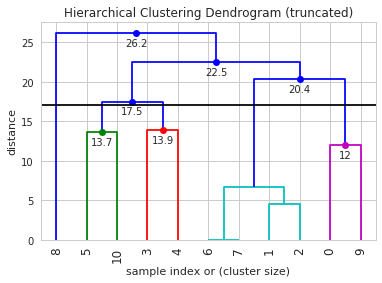

UCHL1 3KW5.A  cophenetic corr: 0.8155769636167086
KEAP1 4L7B.B


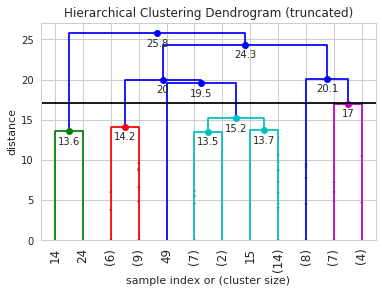

KEAP1 4L7B.B  cophenetic corr: 0.6580070999271632
KEAP1 4CXT.A


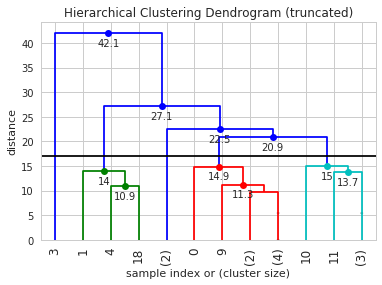

KEAP1 4CXT.A  cophenetic corr: 0.8496756364342599
TXNRD1 3QFB.A


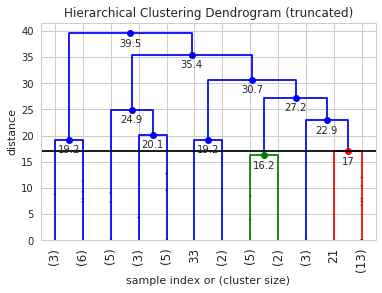

TXNRD1 3QFB.A  cophenetic corr: 0.7347610209189731
RAB6B 2FFQ.A


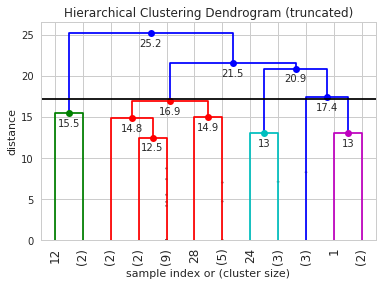

RAB6B 2FFQ.A  cophenetic corr: 0.694046808212339
GSTM3 3GTU.D


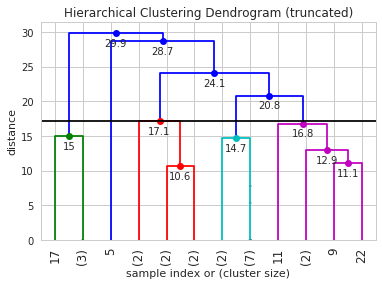

GSTM3 3GTU.D  cophenetic corr: 0.7728163160660774
G6PD 1QKI.F


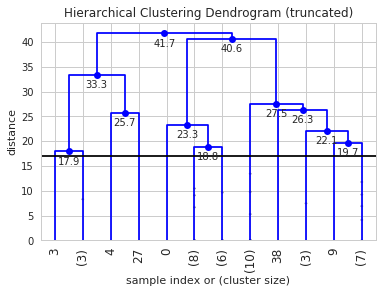

G6PD 1QKI.F  cophenetic corr: 0.7959780075935325
CUL3 4APF.B


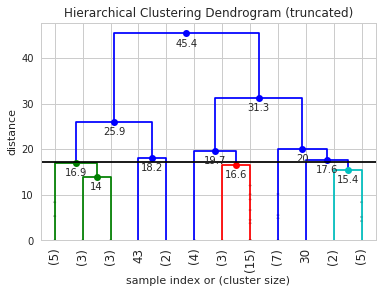

CUL3 4APF.B  cophenetic corr: 0.757093344007328
CUL3 4EOZ.B


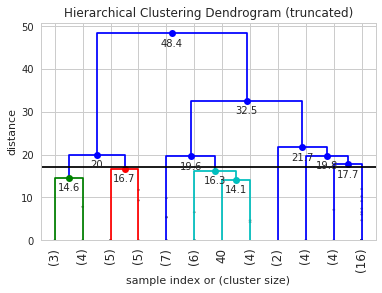

CUL3 4EOZ.B  cophenetic corr: 0.78725533613054
AKR1B10 1ZUA.X


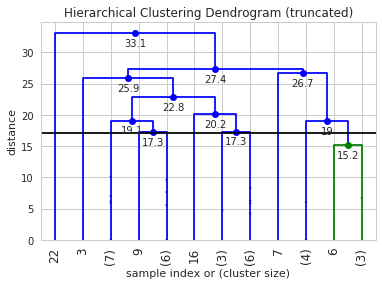

AKR1B10 1ZUA.X  cophenetic corr: 0.6807137292650722
AKR1C4 2FVL.C


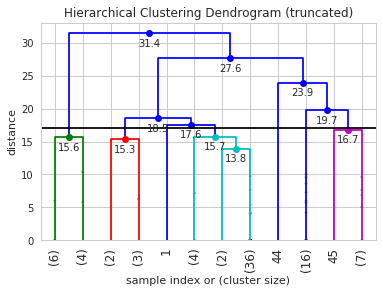

AKR1C4 2FVL.C  cophenetic corr: 0.8683416879506926
SIRT1 5BTR.A


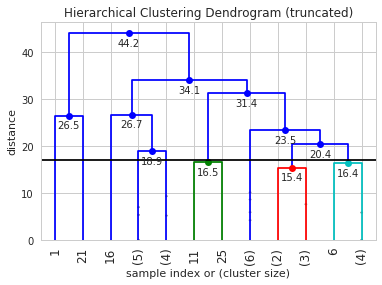

SIRT1 5BTR.A  cophenetic corr: 0.7558487493333284
NTRK2 4AT5.A


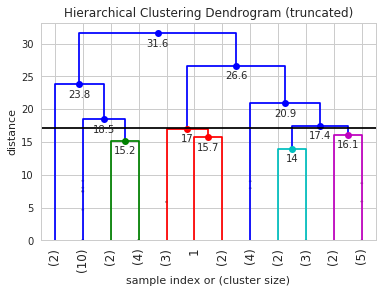

NTRK2 4AT5.A  cophenetic corr: 0.7479668741894266
NTRK2 1WWB.X


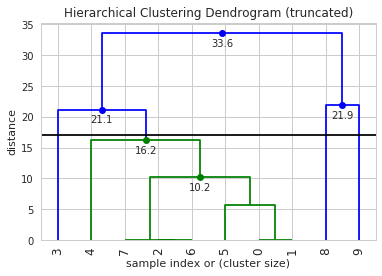

NTRK2 1WWB.X  cophenetic corr: 0.8657664295998113
NFE2L2 4IFL.P


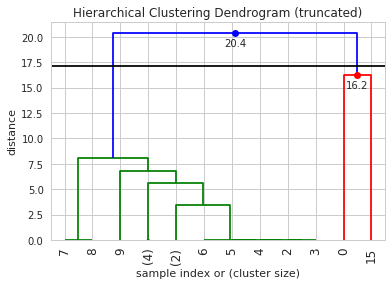

NFE2L2 4IFL.P  cophenetic corr: 0.944349503682256
NFE2L2 2FLU.P


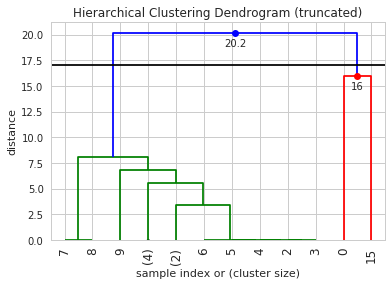

NFE2L2 2FLU.P  cophenetic corr: 0.9457272835675331
AKR1C3 4ZFC.B


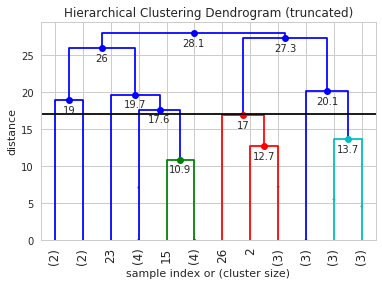

AKR1C3 4ZFC.B  cophenetic corr: 0.708421605549357
AKR1C2 4XO6.B


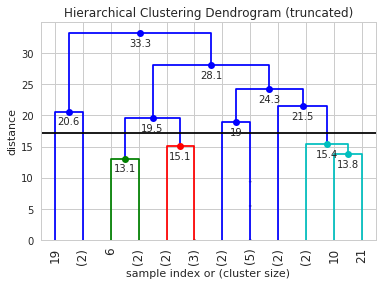

AKR1C2 4XO6.B  cophenetic corr: 0.7182503118299356
SRXN1 2RII.X


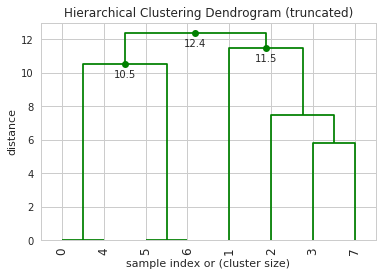

SRXN1 2RII.X  cophenetic corr: 0.8887261938863147
NQO1 5EA2.A


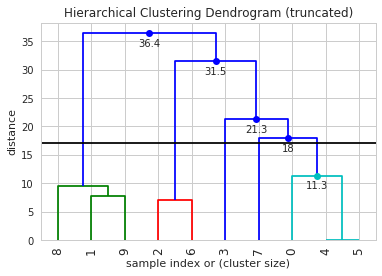

NQO1 5EA2.A  cophenetic corr: 0.8647220670698648


In [9]:
DF_clustering = pd.DataFrame()

for i in df.Hugo_Symbol.unique():
    for j in df[df.Hugo_Symbol==i].structureChainId.unique():
        
        print(i,j)
        
        tt = df[(df.Hugo_Symbol==i)&(df.structureChainId==j)].reset_index()
        
        # generate xyz arrays
        X = tt[['cluster_x','cluster_y','cluster_z']].values
        
        # generate the linkage matrix
        Z = linkage(X, 'average')
        
        fancy_dendrogram(
            Z,
            truncate_mode='lastp',
            p=12,
            leaf_rotation=90.,
            leaf_font_size=12.,
            show_contracted=True,
            annotate_above=10,
            max_d=17.1,
        )
        
        #save plot
        name = i+'_'+j
        plt.savefig("%s_dendrogram.pdf"%(path+name),format="PDF")
        plt.show()
        
        # retreieve clusters by distance cutoff = 17 A  *** NEEDS WORK
        max_d = 17.1
        clusters = fcluster(Z, max_d, criterion='distance')
        tt['clusters'] = clusters
        
        # compute average R across branches
        (DFZ,ttt) = retrieve_R_across_branches(tt,Z)
        DFZ['Hugo_Symbol'] = [i for l in DFZ.index]
        DFZ['structureChainId'] = [j for l in DFZ.index]
        DFZ['ID'] = [name for l in DFZ.index]
        DFZ.reset_index(inplace=True)
        
        # name clusters
        tmp_DFZ = return_cluster_groups(ttt)
        DFZ['group_member_resnum'] = ['' for l in DFZ.index]
        DFZ['cluster_grp'] = ['' for l in DFZ.index]
        DFZ['cluster_level'] = ['' for l in DFZ.index]
        
        for k in tmp_DFZ.index:
            idx1 = tmp_DFZ.loc[k,'idx1']
            idx2 = tmp_DFZ.loc[k,'idx2']
            
            ind = DFZ[(DFZ.idx1==idx1)&(DFZ.idx2==idx2)].index.tolist()
            
            for l in ind:
                DFZ.at[l,'group_member_resnum'] = tmp_DFZ.loc[k,'resnum_of_members']
                DFZ.at[l,'cluster_grp'] = tmp_DFZ.loc[k,'cluster_grp']
                DFZ.at[l,'cluster_level'] = tmp_DFZ.loc[k,'cluster_level']
            
        # store in final DF
        DF_clustering = pd.concat([DF_clustering,DFZ])
        
        # check the Cophenetic Correlation Coefficient of the clustering 
        c, coph_dists = cophenet(Z, pdist(X))
        print(i,j, " cophenetic corr:",c)

## Visualize clusters/branches with boxplots

In [10]:
def cluster_boxplots_filtered_R(ff,dist,path,name):
    for_plot = []
    
    ff = ff[ff.dist<dist][['cluster_grp','R','dist','avg_R_+','avg_R_-']]
    
    list_R = []
    
    # only get clusters where majority of R values are > 0 or < 0
    for i in ff.cluster_grp.unique():
        
        list1 = ff[ff.cluster_grp==i].R.values.tolist()
        dist_list = ff[ff.cluster_grp==i].dist.values.tolist()
        
        # initialize
        pos_count = 0
        neg_count = 0
        
        # enumerate R+ and R- values in list
        only_pos = [num for num in list1 if num >= 0] 
        only_neg = [num for num in list1 if num < 0]
        pos_count = np.true_divide(len(only_pos),len(list1)) 
        neg_count = np.true_divide(len(only_neg),len(list1))
        
        # find sign with majority
        max_sign = np.max([pos_count,neg_count])   #*****************TO DO: change to have high/low Rs in one group
        #print(i,len(list1),only_neg,only_pos,max_sign)
        
        # only keep those with majority of a single sign
        if len(list1) < 3 or max_sign < 0.7:
            pass
        else:
            for j in list1:
                if j==np.nan:
                    pass
                elif j==np.inf:
                    pass
                elif j==None:
                    pass
                elif pd.isnull(j):
                    pass
                else:
                    list_R.append({'cluster_grp':i,'R':j,'dist':np.mean(dist_list)})
            
      
    ff = pd.DataFrame(list_R)
    
    if len(ff)>0:

        w = 10
        h = np.true_divide(len(ff.cluster_grp.unique()),1.5)
        size = (h,w)

        fig, ax = plt.subplots(figsize=size)
        ax = sns.boxplot(x="cluster_grp", y="R", data=ff, palette=["w"],linewidth=2)
        ax = sns.swarmplot(x="cluster_grp", y="R", data=ff, color=".25",size=8)
        sns.despine(offset=10, trim=True)

        minv = np.min(ff['R'].values)-.2
        maxv = np.max(ff['R'].values)+.2

        ax.set(ylim=(minv, maxv))
        ax.axes.set_title(name,fontsize=20)
        ax.tick_params(labelsize=15)
        ax.set_xlabel("Clusters",fontsize=20)
        ax.set_ylabel("R Score",fontsize=20)

        #ax.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)
        plt.setp(ax.get_xticklabels(), rotation=90)
        fig = ax.get_figure()
        fig.savefig("%s_filteredR_boxplots.pdf"%(path+name),format="PDF")
    else:
        print("No data to print")
    return(ff)

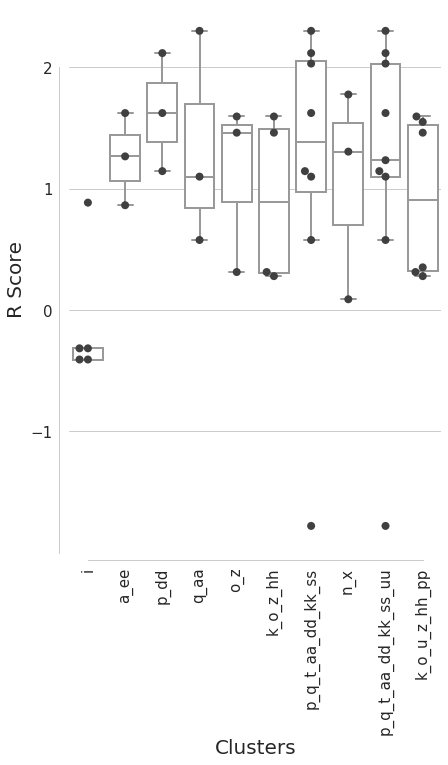

In [11]:
# Example of plotting 1 protein and 1 structure file
hs = 'KEAP1'
p = '4L7B.B'
oo = cluster_boxplots_filtered_R(DF_clustering[(DF_clustering.Hugo_Symbol==hs)&(DF_clustering.structureChainId==p)],20,'','')

,R,cluster_grp,dist
0,1.551126,q,0.000000
1,1.267087,q,0.000000
2,1.551126,q,0.000000
3,1.100177,q,0.000000
4,1.267087,q,0.000000
5,1.551126,q,0.000000
6,1.531444,q,0.000000
7,1.100177,q,0.000000
8,1.267087,q,0.000000
9,1.551126,q,0.000000


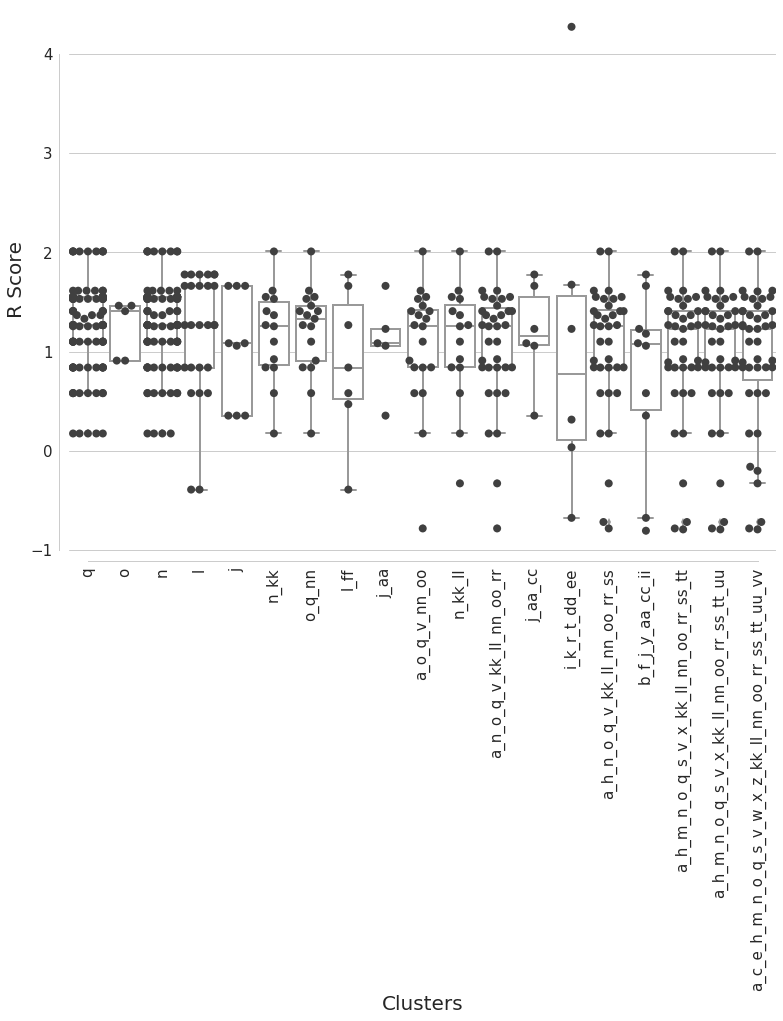

In [12]:
# Example of plotting 1 protein and 1 structure file
hs = 'AKR1C4'
p = '2FVL.C'
cluster_boxplots_filtered_R(DF_clustering[(DF_clustering.Hugo_Symbol==hs)&(DF_clustering.structureChainId==p)],20,'','')

UCHL1 3KW5.A
KEAP1 4L7B.B
KEAP1 4CXT.A
TXNRD1 3QFB.A
RAB6B 2FFQ.A
GSTM3 3GTU.D
No data to print
G6PD 1QKI.F
CUL3 4APF.B
CUL3 4EOZ.B
AKR1B10 1ZUA.X
AKR1C4 2FVL.C
SIRT1 5BTR.A
NTRK2 4AT5.A
NTRK2 1WWB.X
No data to print
NFE2L2 4IFL.P
No data to print
NFE2L2 2FLU.P
No data to print
AKR1C3 4ZFC.B
AKR1C2 4XO6.B
SRXN1 2RII.X
No data to print
NQO1 5EA2.A


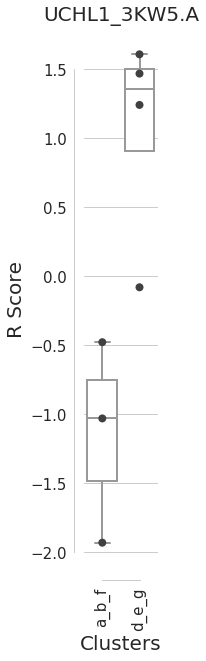

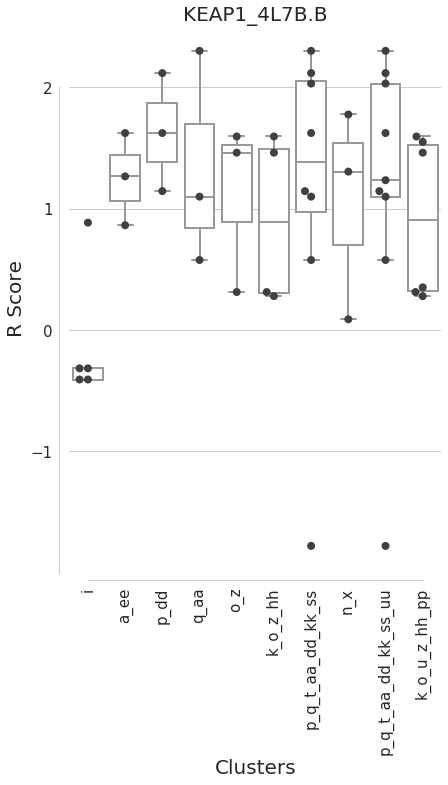

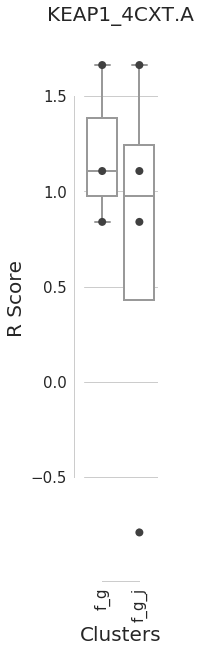

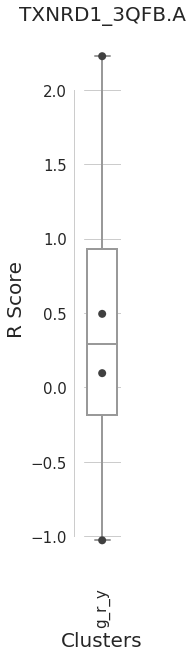

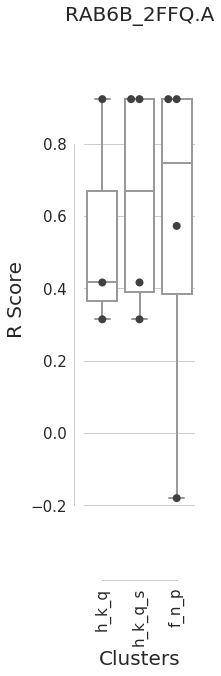

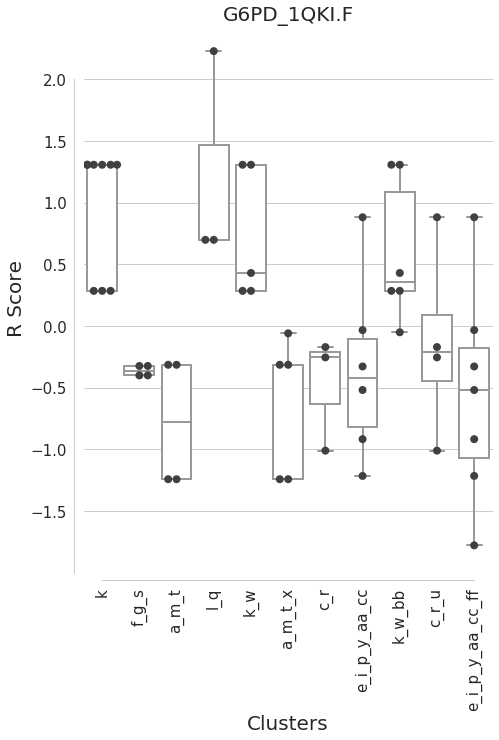

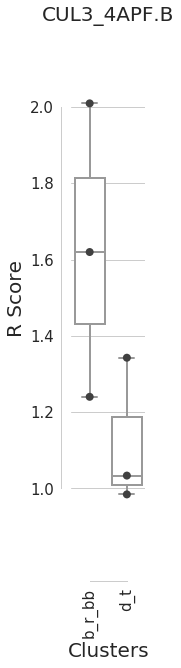

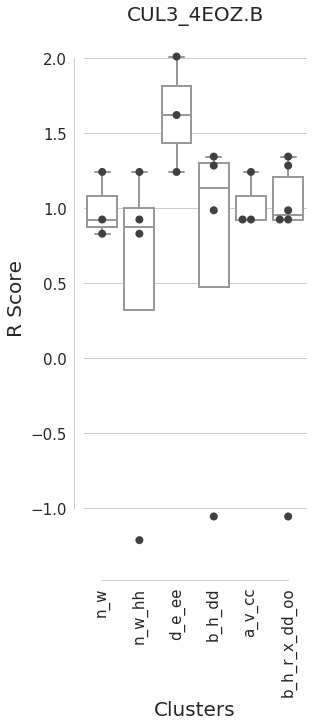

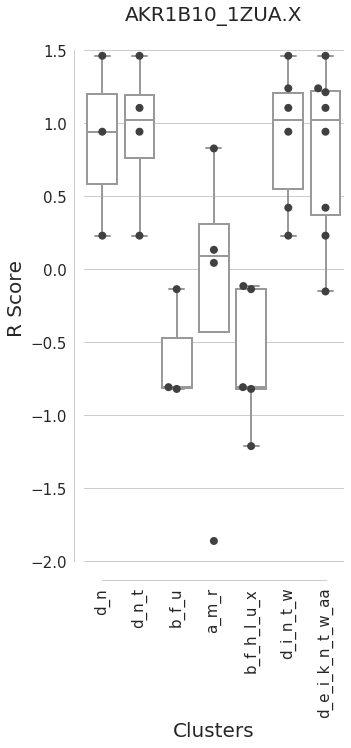

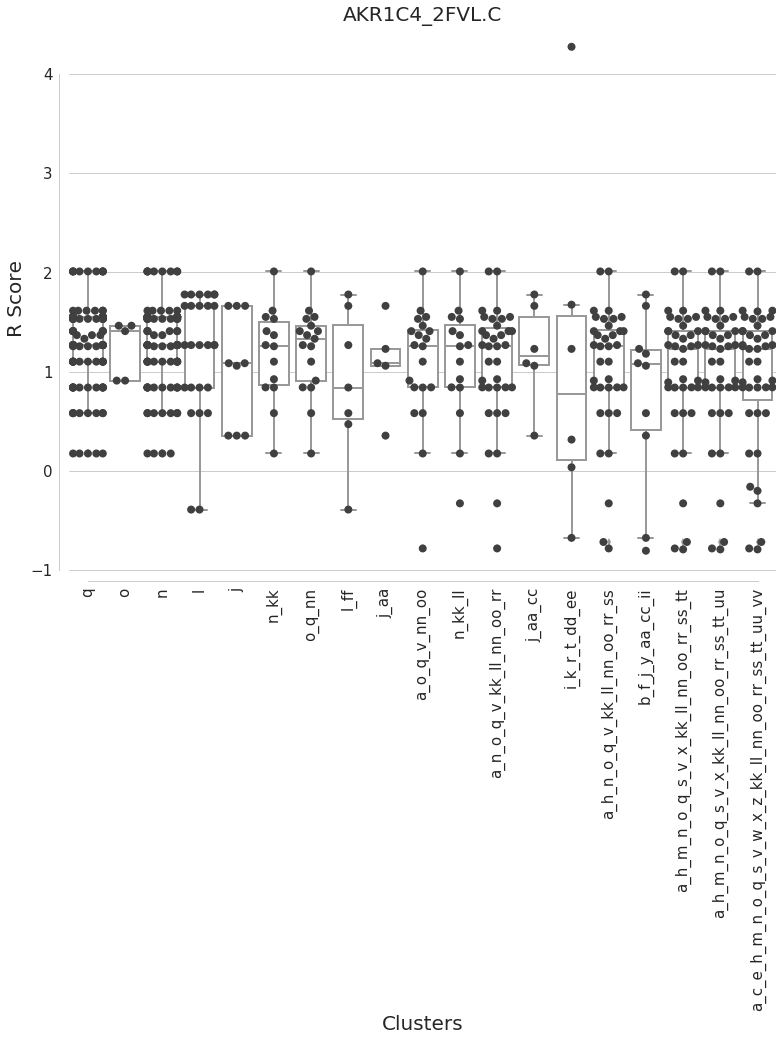

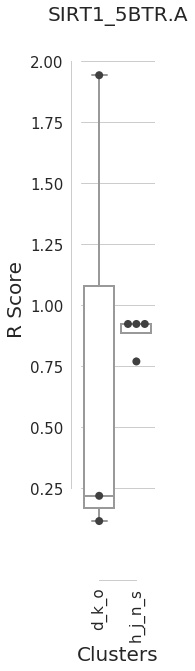

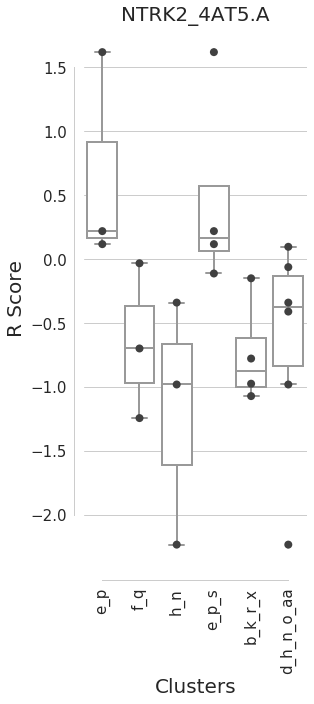

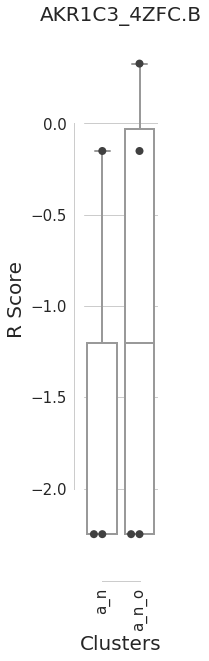

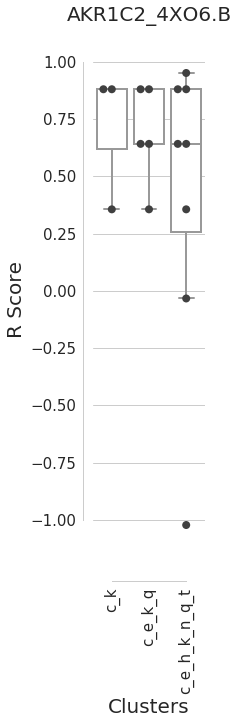

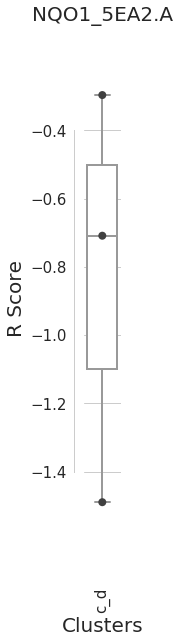

In [13]:
for i in DF_clustering.Hugo_Symbol.unique():
    for j in DF_clustering[DF_clustering.Hugo_Symbol==i].structureChainId.unique():
        ff = DF_clustering[(DF_clustering.Hugo_Symbol==i)&(DF_clustering.structureChainId==j)]
        print(i,j)
        name = i+'_'+j
        tmp = cluster_boxplots_filtered_R(ff,20,path,name)
        
        

#### Select branch to visualize resisdues in that branch (below)

In [17]:
gene = 'TXNRD1'
struct = '3QFB.A'
branch = 'v_hhh'

In [14]:
gene = 'AKR1C4'
struct = '2FVL.C'
branch = 'i_k_r_t_dd_ee'

In [15]:
df_detailed[(df_detailed.Hugo_Symbol==gene)&(df_detailed.structureChainId==struct)&(df_detailed.Protein_Change=='p.A122V')]

,index,Hugo_Symbol,Protein_Change,Tumor_Sample_Barcode,variationId,uniprotId,structureChainId,targetGroupId,targetChainId,targetGroupNumber,cluster_x,cluster_y,cluster_z,atom_nom,PDB_CHAIN_ID,SP_PRIMARY,GENE,coverage,PTM_dist,PTM_type,PTM_resName,PTM_resNum,Ligand_dist,Ligand_resName,Ligand_resNum,Drug_dist,Drug_resName,Drug_resNum,Drug_DrugBankId,Drug_Name,Drug_Inchi,Drug_CAS,Drug_ChEMBLID


In [16]:
DF_clustering[(DF_clustering.Hugo_Symbol==gene)&(DF_clustering.structureChainId==struct)&(DF_clustering.cluster_grp==branch)]

,index,idx1,idx2,dist,num_members,index_of_members,member_idx,group_member_idx,pdbResNum,R,Tumor_Sample_Barcode,Protein_Change,uniprotId,var_x,var_y,var_z,num_with_R,avg_R_+,std_R_+,num_with_R+,avg_R_-,std_R_-,num_with_R-,avg_abs_R,std_abs_R,Hugo_Symbol,structureChainId,ID,group_member_resnum,cluster_grp,cluster_level
450,68,4,144,11.9738,7,"[4, 77, 36, 82, 3, 79, 80]",4,"[4, 77, 36, 82, 3, 79, 80]",309,1.67455,DU145_PROSTATE,p.D309E,P17516,52.907,38.3015,65.7345,6,1.5054,1.50712,5,-0.676603,0,1,1.36727,1.41005,AKR1C4,2FVL.C,AKR1C4_2FVL.C,"[309.0, 122.0, 139.0, 139.0, 310.0, 120.0, 118.0]",i_k_r_t_dd_ee,6
451,68,4,144,11.9738,7,"[4, 77, 36, 82, 3, 79, 80]",77,"[4, 77, 36, 82, 3, 79, 80]",122,NaN,SARC9371_BONE,p.L122F,P17516,43.03,29.2845,59.849,6,1.5054,1.50712,5,-0.676603,0,1,1.36727,1.41005,AKR1C4,2FVL.C,AKR1C4_2FVL.C,"[309.0, 122.0, 139.0, 139.0, 310.0, 120.0, 118.0]",i_k_r_t_dd_ee,6
452,68,4,144,11.9738,7,"[4, 77, 36, 82, 3, 79, 80]",36,"[4, 77, 36, 82, 3, 79, 80]",139,1.22877,HCC2814_LUNG,p.F139F,P17516,42.194,36.115,59.989,6,1.5054,1.50712,5,-0.676603,0,1,1.36727,1.41005,AKR1C4,2FVL.C,AKR1C4_2FVL.C,"[309.0, 122.0, 139.0, 139.0, 310.0, 120.0, 118.0]",i_k_r_t_dd_ee,6
453,68,4,144,11.9738,7,"[4, 77, 36, 82, 3, 79, 80]",82,"[4, 77, 36, 82, 3, 79, 80]",139,4.27486,SNU878_LIVER,p.F139F,P17516,42.194,36.115,59.989,6,1.5054,1.50712,5,-0.676603,0,1,1.36727,1.41005,AKR1C4,2FVL.C,AKR1C4_2FVL.C,"[309.0, 122.0, 139.0, 139.0, 310.0, 120.0, 118.0]",i_k_r_t_dd_ee,6
454,68,4,144,11.9738,7,"[4, 77, 36, 82, 3, 79, 80]",3,"[4, 77, 36, 82, 3, 79, 80]",310,0.314104,SNU175_LARGE_INTESTINE,p.F310S,P17516,50.467,31.114,62.424,6,1.5054,1.50712,5,-0.676603,0,1,1.36727,1.41005,AKR1C4,2FVL.C,AKR1C4_2FVL.C,"[309.0, 122.0, 139.0, 139.0, 310.0, 120.0, 118.0]",i_k_r_t_dd_ee,6
455,68,4,144,11.9738,7,"[4, 77, 36, 82, 3, 79, 80]",79,"[4, 77, 36, 82, 3, 79, 80]",120,0.0347364,EFM192A_BREAST,p.M120V,P17516,43.604,30.888,66.578,6,1.5054,1.50712,5,-0.676603,0,1,1.36727,1.41005,AKR1C4,2FVL.C,AKR1C4_2FVL.C,"[309.0, 122.0, 139.0, 139.0, 310.0, 120.0, 118.0]",i_k_r_t_dd_ee,6
456,68,4,144,11.9738,7,"[4, 77, 36, 82, 3, 79, 80]",80,"[4, 77, 36, 82, 3, 79, 80]",118,-0.676603,MEWO_SKIN,p.F118F,P17516,47.201,27.593,67.877,6,1.5054,1.50712,5,-0.676603,0,1,1.36727,1.41005,AKR1C4,2FVL.C,AKR1C4_2FVL.C,"[309.0, 122.0, 139.0, 139.0, 310.0, 120.0, 118.0]",i_k_r_t_dd_ee,6


#### save output dataframes

In [18]:
DF_clustering.to_csv(output_file_name)
DF_clustering.head(2)

,index,idx1,idx2,dist,num_members,index_of_members,member_idx,group_member_idx,pdbResNum,R,Tumor_Sample_Barcode,Protein_Change,uniprotId,var_x,var_y,var_z,num_with_R,avg_R_+,std_R_+,num_with_R+,avg_R_-,std_R_-,num_with_R-,avg_abs_R,std_abs_R,Hugo_Symbol,structureChainId,ID,group_member_resnum,cluster_grp,cluster_level
0,0,6,7,0,2,"[6, 7]",6,"[6, 7]",207,-1.92954,OC316_OVARY,p.R207H,P09936,40.1565,61.2805,68.6085,2,None,None,0,-1.20367,0.725862,2,1.20367,0.725862,UCHL1,3KW5.A,UCHL1_3KW5.A,"[207.0, 207.0]",a,1
1,0,6,7,0,2,"[6, 7]",7,"[6, 7]",207,-0.477812,OC314_OVARY,p.R207H,P09936,40.1565,61.2805,68.6085,2,None,None,0,-1.20367,0.725862,2,1.20367,0.725862,UCHL1,3KW5.A,UCHL1_3KW5.A,"[207.0, 207.0]",a,1


## Visualize clusters in 3D

In [19]:
colors = ['red','blue','yellow','orange','green','purple','black']

def view_grouped_mutations(grouped_df, *args):
    chainIds = list(grouped_df.groups.keys())

    def view3d(show_bio_assembly=False, show_surface=False, show_labels=True, i=0):
        group = grouped_df.get_group(chainIds[i])
        
        pdb_id, chain_id = chainIds[i].split('.')
        viewer = py3Dmol.view(query='pdb:' + pdb_id, options={'doAssembly': show_bio_assembly})

        # polymer style
        viewer.setStyle({'cartoon': {'colorscheme': 'chain', 'width': 0.6, 'opacity':0.9}})
 
        # highlight chain of interest in blue
        viewer.setStyle({'chain': chain_id},{'cartoon': {'color': 'blue'}})
        
        # non-polymer style
        viewer.setStyle({'hetflag': True}, {'stick':{'radius': 0.3, 'singleBond': False}})
    
        # don't display water molecules
        viewer.setStyle({'resn': ['HOH','DOD']}, {})
        
        rows = group.shape[0]
        for j in range(0, rows):
            res_num = str(group.iloc[j]['pdbResNum'])
            mod_res = {'resi': res_num, 'chain': chain_id} 
            clust = group.iloc[j]['cluster']
            if clust == -1:
                col = 'black'
            else:
                col = colors[clust]
            c_col = col + 'Carbon'
            viewer.addStyle(mod_res, {'stick':{'colorscheme':c_col, 'radius': 0.2}})
            viewer.addStyle(mod_res, {'sphere':{'color':col, 'opacity': 0.6}})          
            if show_labels:
                label = np.round(group.iloc[j]['R'],decimals=2)
                viewer.addLabel(label, {'fontSize':10,'fontColor': 'black','backgroundColor':'ivory'}, {'resi': res_num, 'chain': chain_id})
        
        viewer.zoomTo({'chain': chain_id})
        
        if show_surface:
             viewer.addSurface(py3Dmol.SES,{'opacity':0.8,'color':'lightblue'},{'chain': chain_id})
                
        #print header
        print("PDB Id: " + pdb_id + " chain Id: " + chain_id)
                
        return viewer.show()
       
    s_widget = IntSlider(min=0, max=len(chainIds)-1, description='Structure', continuous_update=False)
    
    return interact(view3d, show_bio_assembly=False, show_surface=False, show_labels=True, i=s_widget)

In [21]:
g = 'KEAP1'
p = '4L7B.B'
branch = 'p_q_t_aa_dd_kk_ss'

dfx = DF_clustering[(DF_clustering.Hugo_Symbol==g)&(DF_clustering.structureChainId==p)]

dfx = dfx[dfx.cluster_grp==branch]

dfx['cluster'] = [0 for i in dfx.index]

In [22]:
chains = dfx.groupby('structureChainId')
print("Chains:", list(chains.groups.keys()))
view_grouped_mutations(chains);

Chains: ['4L7B.B']


interactive(children=(Checkbox(value=False, description='show_bio_assembly'), Checkbox(value=False, descriptio…

## Split Data into Test / Train sets

In [28]:
DF_clustering.head(2)

,index,idx1,idx2,dist,num_members,index_of_members,member_idx,group_member_idx,pdbResNum,R,Tumor_Sample_Barcode,Protein_Change,uniprotId,var_x,var_y,var_z,num_with_R,avg_R_+,std_R_+,num_with_R+,avg_R_-,std_R_-,num_with_R-,avg_abs_R,std_abs_R,Hugo_Symbol,structureChainId,ID,group_member_resnum,cluster_grp,cluster_level
0,0,6,7,0,2,"[6, 7]",6,"[6, 7]",207,-1.92954,OC316_OVARY,p.R207H,P09936,40.1565,61.2805,68.6085,2,None,None,0,-1.20367,0.725862,2,1.20367,0.725862,UCHL1,3KW5.A,UCHL1_3KW5.A,"[207.0, 207.0]",a,1
1,0,6,7,0,2,"[6, 7]",7,"[6, 7]",207,-0.477812,OC314_OVARY,p.R207H,P09936,40.1565,61.2805,68.6085,2,None,None,0,-1.20367,0.725862,2,1.20367,0.725862,UCHL1,3KW5.A,UCHL1_3KW5.A,"[207.0, 207.0]",a,1


In [27]:
target_data = DF_clustering[['Tumor_Sample_Barcode','R']].drop_duplicates()

In [ ]:
output_name_1 = 'split_target_data'

for i in range(20):
    msk = np.random.rand(len(target_data)) < 0.8
    train = target_data[msk]
    test = target_data[~msk]
    
    #save 
    train.to_csv(path_test_train+output_name_1+'_train_%s.csv'%(str(i)))
    test.to_csv(path_test_train+output_name_1+'_test_%s.csv'%(str(i)))